<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Assignment 1 
## Question 1: Classifying Digits
For this question we are going to be tackling a simple optical character recognition problem: identifying images of hand-written digits using a dataset called MNIST, which is immensely popular for use in introductory ML courses. I have provided you the model to use below (and at this point in the course you can treat it as a “black box”).  The objective of this problem is to identify the optimal value of a particular hyperparameter for the model by using the validation strategies we have learned in class.  

After you have added your code, restart your kernel and run the notebook from the top to ensure all cells run properly.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

In [2]:
# Load the dataset we will use
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

As we can see above, we have 1797 observations of hand-written digits, each with a shape of 8x8 pixels.  Let's now visualize some of them so we can understand better what they look like.

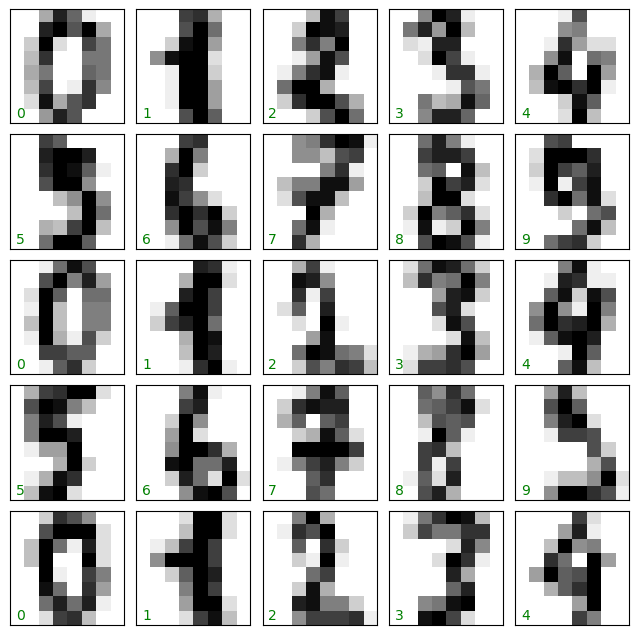

In [3]:
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

# subplot_kw = arguments to be passed to each of the axes in the subplots directly
# gridspec_kw = when you need more control over spacing and arrangement of subplots

# axes.flat is a convenient way to get all axes at the same time

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

Above we can see 25 of the digit images, with the digit label shown in small green font at lower left.  In our modeling project, we will use the values of each pixel (64 in total per image: 8x8) as the features of our input to the model.  Our target will be the image labels indicating what digit the image represents.

As we know, to use the Scikit-Learn models our input data is expected to be in the shape [n_observations, n_features].  To get our input data into this form, we need to flatten our image pixel matrix from 8x8 to 1x64 (each row has 64 features - one feature representing each pixel).  Fortunately, someone has already done this for us and we can read the data in using the proper shape as shown below.

In [4]:
# Read in the input and target data
X = digits.data
y = digits.target
print(X.shape,y.shape)

# X shape = (N, 64)
# Y shape = (N,)

(1797, 64) (1797,)


## Q1.1: Train and test a KNN classification model (8 pts)
In this part, we will practice training and evaluating performance of models using a simple K-Nearest-Neighbors (KNN) classifier model.  You do not need to worry about how this model works at this point, but if you are curious, for each datapoint that is fed to it to generate a prediction, it identifies the "*n_neighbors*" (a hyperparameter you can adjust) closest datapoints to it found in the training dataset (using either Euclidian distance or another similarity metric) and returns the target label most common to the *n_neighbors* neighbor points.  For example, if you feed an image to the KNN classifier and it identifies that most of the nearby points to the image are labeled as "3", it will predict that the image you have just provided is also a "3".

For this first part, I have provided the code to set up the model below.  What I would like you to do is to complete the function `model_digits()` which accepts as input the input data `X` and the target labels `y` defined above, a model `model`, a value for `random_state` and a value for percentage of data to use in the test set `test_size`.

The function should do the following:  
- Split the data (X and y) into a training and set set using 80% for the training set and 20% for the test set.  Be sure to set `random_state=0` when splitting the data and stratify based on the target labels
- Fit your model using the training data  
- Get the predictions on the test set and calculate accuracy of the test set predictions

Your function should return the accuracy of the test set predictions.

In [5]:
def model_digits(X,y,model,random_state=0,test_size=0.2):
    '''
    Splits the data, trains a model and evaluates the model predictions on the test set using accuracy

    Inputs:
        X(np.ndarray): training data inputs
        y(np.ndarray): training data targets
        model(sklearn.base.BaseEstimator): instantiated scikit-learn model object
        random_state(int): random seed to use for splitting data
        test_size(float): proportion of data to use for the test set

    Returns:
        acc_test(float): accuracy of the test set predictions
    '''
    # Still unsure what stratify = y means
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = test_size, random_state = random_state, stratify = y)

    # Y_train is of size (m, )
    model.fit(X_train, Y_train)
    y_predicted = model.predict(X_test)
    accuracy = (y_predicted == Y_test).sum() / (y_predicted.size)
    return accuracy

In [6]:
## Additionally defining own implementation of KNN

class KNN:
    
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
    
    
    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, test):
        y_pred = []
        for x in test:
            X_subtracted = self.X - x
            norms = np.linalg.norm(X_subtracted, axis = 1)
            idxs_sort_by_distances = norms.argsort()
            top_k_idxs = idxs_sort_by_distances[:self.n_neighbors]
            nearest_neighbour_labels = self.y[top_k_idxs]
            pred_value = np.bincount(nearest_neighbour_labels).argmax()
            y_pred.append(pred_value)

        return np.array(y_pred)

In [7]:
knn = KNN(5)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
acc = (y_pred == Y_test).sum() / (Y_test.size)
print(acc)

0.975


In [8]:
# Test cell

# Set up the model we will use
knn_model = KNeighborsClassifier(n_neighbors=5)

# Apply your function
acc_test = model_digits(X,y,knn_model,random_state=0,test_size=0.2)
print('Accuracy of your classifier on the test set is {:.3f}'.format(acc_test))

assert np.round(acc_test,2)==0.98
print('Passed test')

Accuracy of your classifier on the test set is 0.978
Passed test


## Q1.2A: Perform algorithm selection using a validation set (12 pts)
In this part, we will compare performance of two different classifer algorithms: a KNN model as above and a multilayer perceptron (neural network) model.  We will not do any hyperparameter tuning for either model, but rather will focus on comparing the two algorithms as they are provided in the cell below.  Your task is to compare models using a fixed validation set (NOT cross-validation, yet).  

To do this, complete the below function `compare_models()` which takes as input the data `X` and labels `y` defined above, a list of models to compare, the percentage of data to use for the test set `test_size`, and the percentage of the training set to use for validation `val_size`.

Your function should do the following:  
- Split your data into a test set and training set using the input `test_size`, being sure to use `random_state=0` while splitting and stratify based on the target labels 
- Further split your training set into a validation set and training subset using `val_size`, being sure to use `random_state=0` while splitting and stratify based on the target labels 
- Fit each model on the training set  
- Get the predictions of each model on the validation set and calculate the validation accuracy. 
- Select the model with the higher validation accuracy as your final model. 
- Retrain your final selected model on the combined training+validation set
- Using your retrained final model, calculate the predictions on the test set and the accuracy of the test set predictions. 

Your function should return your selected best model and the test set accuracy performance of your selected model.

In [9]:
def compare_models(X,y,models,test_size,val_size,random_state=0):
    '''
    Splits data to create validation and test sets, compares models based on validation set performance and then calculates the 
    test set accuracy of the model with the highest validation set performance

    Inputs:
        X(np.ndarray): input data
        y(np.ndarray): labels
        models(list): list of instantiated scikit-learn model objects
        test_size(float): proportion of the data to use for the test set
        val_size(float): proportion of the training set data to use as a validation set
        random_state(int): random seed to use for splitting data

    Returns:
        best_model(sklearn.base.BaseEstimator): model with the highest validation set performance
        acc_test(float): accuracy of the best model on the test set
    '''
    X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state = random_state, stratify = y)
    X_train, X_val, y_train, y_val =  train_test_split(X_Train, y_Train, test_size = val_size, random_state=random_state, stratify=y_Train)

    assert(X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0])
    assert(y_train.shape[0] + y_val.shape[0] + y_test.shape[0] == y.shape[0])

    acc_list = []
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        acc = (y_pred == y_val).sum() / y_pred.size
        acc_list.append(acc)
    
    # Picking out the best model
    idx_best_model = np.argmax(acc_list)
    best_model = models[idx_best_model]
    
    # Training the best model now on the complete training data
    best_model.fit(X_Train, y_Train)

    y_Pred = best_model.predict(X_test)
    acc = (y_Pred == y_test).sum() / y_Pred.size
    return best_model, acc

In [10]:
# Test cell

# Set up the two models to compare
model_knn = KNeighborsClassifier(n_neighbors=5)
model_mlp = MLPClassifier(hidden_layer_sizes=(100,50),activation='relu',
                      solver='sgd',learning_rate_init=0.01,max_iter=2000)
models = [model_knn,model_mlp]

best_model, testacc = compare_models(X,y,models,test_size=0.2,val_size=0.3,random_state=0)
print('Accuracy of your final model on the test set is {:.3f}'.format(testacc))

assert best_model == model_knn
assert np.round(testacc,2) == 0.98
print('Passed tests')

Accuracy of your final model on the test set is 0.978
Passed tests


## Q1.2B (10 pts)
In Q1.2A, we compared two different algorithms by using their accuracy score on the validation set to select the better performing algorithms.  When working on a real-life industry project, list at least two other considerations when selecting an algorithm to use.  Then, for each of the two considerations you list, provide an example of a situation when your algorithm selection decision would be heavily influenced by this criterion and explain why it would heavily influence your choice.

### Solution:
1)	Interpretability of the model  
2)	Computational resources required to train and run model

5pts for each.  For full credit must also provide a reasonable example of when each criterion would be important and explain why.  -3 points for each of no example is provided.

Student can get credit for other criteria besides the 2 above if the criteria they list are reasonable considerations when selecting an algorithm.  


## Q1.3: Tune hyperparameters using cross-validation (15 pts)
For this part, we are again going to use the KNN algorithm which we used above.  However, rather than leaving its hyperparameter *n_neighbors* at a fixed value, we are going to run it with different values and determine which value gives us the best performance.  We will then use that in our final model.  To compare versions of the model using different values of *n_neighbors* we will use cross-validation.

Your objective is to find the optimal value of `n_neighbors` using cross-validation and then to evaluate the performance of your best model.  To do this, complete the below function `crossval_compare()` which takes as input the data `X` and labels `y`, a list of values `neighbors_list` to try for the hyperparameter `n_neighbors` of the model, the number of iterations `k` to use in the cross-validation, the amount of data to reserve for the test set `test_size`, and `random_state=0`.  

Your function should perform the following:  
- Split the data into training and test sets.  Be sure to set `random_state=0` and stratify using the target labels
- For each integer value `n` in the list `neighbors_list`:
    - Instantiate a KNeighborsClassifier model setting `n_neighbors = n`  
    - Perform a K-folds cross-validation, training the model on the training folds then evaluating the accuracy of the model on the validation fold.  Set `shuffle=False` (done by default) when performing the K-fold cross validation
    - Calculate and store the mean validation accuracy
- Identify the value of `n_neighbors` which yielded the highest mean validation accuracy  
- Create a final KNeighborsClassifier model using the optimal `n_neighbors` value from above. 
- Fit your final model and then use it to get the predictions for the test set. 
- Calculate the accuracy of your final model on the test set

Your function should return a tuple of the optimal value of `n_neighbors` from the range as an integer, and the accuracy of your final optimal model on the test set as a float.

Note: you may NOT use scikit-learn's `cross_val_score()` method for this.  You may only use what is imported for you at top of the notebook.

In [11]:
def crossval_compare(X,y,n_list,k,test_size,random_state=0):
    '''
    Use cross-validation to determine the optimal value of the hyperparameter n_neighbors from the input list and then
    calculate the accuracy of the model using the optimal n_neighbors on the test set

    Inputs:
        X(np.ndarray): input data
        y(np.ndarray): labels
        n_list(list): list of possible values for n_neighbors hyperparameter
        k(int): number of folds to use for k-folds cross validation
        test_size(float): proportion of the data to use for the test set
        random_state(int): random seed to use for splitting data

    Returns:
        opt_nval(int): the optimal n_neighbors value from the input list which results in the highest cross-validated performance
        acc_test(float): the accuracy of the best model (using opt_nval) on the test set
    '''
    kf = KFold(n_splits=k)
    X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state, stratify=y)
    mean_accs = []
    for n_neighbours in n_list:
        model = KNeighborsClassifier(n_neighbors=n_neighbours)
        acc_vals = []
        for train_idx, val_idx in kf.split(X_Train):
            X_train, y_train = X_Train[train_idx], y_Train[train_idx]
            model.fit(X_train, y_train)
            X_val, y_val = X_Train[val_idx], y_Train[val_idx]
            y_pred = model.predict(X_val)
            acc = (y_pred == y_val).sum() / (y_pred.size)
            acc_vals.append(acc)
        mean_accs.append(np.mean(acc_vals))

    optimal_n_neighbours = n_list[np.argmax(mean_accs)]

    optimal_model = KNeighborsClassifier(n_neighbors=optimal_n_neighbours)
    optimal_model.fit(X_Train, y_Train)

    y_Pred = optimal_model.predict(X_test)
    acc = (y_Pred == y_test).sum() / (y_Pred.shape[0])
    return optimal_n_neighbours, acc


In [12]:
# Test cell
neighbors_list = range(2,20,1)
k=3
opt_n, testacc = crossval_compare(X,y,neighbors_list,k,test_size=0.25,random_state=0)
print('Your function found the optimal value of n_neighbors to be {}'.format(opt_n))
print('Your function calculated the accuracy of your final model as {:.3f}'.format(testacc))

assert (opt_n == 6)
assert np.round(testacc,2) >= 0.98
print('Passed tests')

Your function found the optimal value of n_neighbors to be 6
Your function calculated the accuracy of your final model as 0.976
Passed tests


## Question 2 (12 pts)
For each of the following tasks, please indicate what type of machine learning you would apply and support your answer with a justification as to why you have chosen that type.  Some of them could be accomplished in multiple ways – in this case please choose the single most likely approach.  If you select “supervised ML”, please also indicate if you would use a “regression” or “classification” model.  
a)     Build a system capable of playing a complex card game  
b)    Build a system that uses your video doorbell to recognize faces and alert you to who is at the door  
c)     Build a system that can go through your emails and group them into groups of similar type to enable more efficient responding, without you having to explicitly specify what the groups should be  
d)    Build a system that can predict your time in your next running race


YOUR ANSWER HERE:

a) For a complex card game, you would need an ML algorithm like reinforcement learning, since it can learn from a rewards-punishment system and improve it's decision making over several iterations of playing the game.

b) A facial recognition system would need to classify the different faces, so it would be a supervised learning algorithm, and it would be a classification model.

c) Grouping without labeling would come under unsupervised learning, like a clustering algorithm of sorts. A k-means clustering could be useful.

d) Prediction of time as a real number would be a supervised learning algorithm, of type regression, since a real number is to be predicted. A linear regression model could come in handy.

### Solution
a)     Build a system capable of playing a complex card game  
* 3pts
* REINFORCEMENT LEARNING
* For full credit must explain why, otherwise -1.5  

b)    Build a system that uses your video doorbell to recognize faces and alert you to who is at the door  
* 3pts
* SUPERVISED LEARNING, CLASSIFICATION
* For full credit must explain why, otherwise -1.5


c)     Build a system that can go through your emails and group them into groups of similar type to enable more efficient responding, without you having to explicitly specify what the groups should be  
* 3pts
* UNSUPERVISED LEARNING
* For full credit must explain why, otherwise -1.5


d)    Build a system that can predict your time in your next running race
* 3pts
* SUPERVISED LEARNING, REGRESSION
* For full credit must explain why, otherwise -1.5



## Question 3 (13 pts)
R-squared can be understood to be a standardized version of Mean Squared Error (MSE).  What is the mathematical relationship between R-squared and MSE for a regression model?  
 
In your answer please use equations (for example showing R-squared in terms of MSE or MSE in terms of R-squared) and then also include text describing (in written words) what the equations you have included mean in plain language.  You can optionally include a graph/image if helpful, but do not need to do so for full credit.

YOUR ANSWER HERE:
SSR is the sum of squares regression, which is the square of difference of predicted value and the mean of the dependent variable, summed over all data points:

$$
SSR = \sum_{i=1}^n (\widehat{y_i} - \mu_y)^2
$$

SSE is the sum of squares error, which is the square of difference of predicted value and the true value of the dependent variable.
$$
SSE = \sum_{i=1}^n (y_i - \widehat{y_i})^2
$$

SST is the sum of squares total, which is the square of difference of true value of dependent variable and the mean.

$$
SST = \sum_{i=1}^n (y_i - \mu_y)^2
$$

If we write SST as follows:

$$
SST = \sum_{i=1}^n (y_i - \mu_y)^2 = \sum_{i=1}^n (y_i - \widehat{y_i} + \widehat{y_i} - \mu_y)^2 = \sum_{i=1}^n (y_i - \widehat{y_i})^2 + \sum_{i=1}^n(\widehat{y_i} - \mu_y)^2 + 2.\sum_{i=1}^n(y_i - \widehat{y_i})((\widehat{y_i} - \mu_y))
$$

When we assume a linear regression model and optimize model parameters for the minimum square error, we get parameters such that the [last term in the last equation becomes 0](https://math.stackexchange.com/questions/709419/prove-sst-ssessr)

So 
$$
SST = SSE + SSR
$$

R^2 is defined as:
$$
R^2 = \frac{SSR}{SST} = \frac{SST - SSE}{SST} = 1 - \frac{SSE}{SST} 
$$


Dividing numerator and denominator by n in the last term, we get

$$
R^2 = 1 - \frac{MSE}{Var(y)}
$$

R^2 denotes how much of the variation in the dependent variable is predictable from the independent variable.

### Solution
<!-- $$
R^2=SSR/SST=1-SSE/SST=1-\ (\sum_(i=1)^n(y_i-y\ \widehat_i\ )^2\ )/(\sum_(i=1)^n(y_i-\mu_y\ )^2\ )=1-\ \ (1/n\ \sum_(i=1)^n\of(y_i-y\ \widehat_i\ )^2\ )/(1/n\ \sum_(i=1)^n\of(y_i-\mu_y\ )^2\ )=1-MSE/(Var(y))
$$ -->
$$
R^2 = \frac{SSR}{SST} = 1 - \frac{SSE}{SST} = 1 - \frac{\sum_{i=1}^n (y_i - \widehat{y_i})^2}{\sum_{i=1}^n (y_i - \mu_y)^2} = 1 - \frac{\frac{1}{n} \sum_{i=1}^n (y_i - \widehat{y_i})^2}{\frac{1}{n} \sum_{i=1}^n (y_i - \mu_y)^2} = 1 - \frac{MSE}{\text{Var}(y)}
$$

* For full credit, student must also explain the above relationship in a couple of sentences.  
* If student’s equations are incorrect, partial credit can be given depending on severity.  
    * Very wrong -8
    * Slightly wrong -4.  
* If student put correct equations but did not include text describing them, -6.


## Question 4 (10 pts)
Suppose we are working on a binary classification problem where we know we have a high class imbalance in the target labels.  Answer the following questions:  
1)    Should we use accuracy, recall, or F1 score as a metric for evaluation of our model?  Why?  
2)    Instead suppose we would like to vary our model threshold and look at its robustness.  Would it be better to use the ROC curve (and AUROC) or the PR curve (and AP) to do so? Why?

YOUR ANSWER HERE:
1. Since F1 score is the harmonic mean of precision and recall, it considers both metrics with equal weightage. Hence the F1 score should be used as a metric. 

2. For a high class imbalance, a PR curve would be better since it doesn't factor in true negatives. An ROC curve does factor in true negatives.

### Solution

1)    Should we use accuracy, recall, or F1 score as a metric for evaluation of our model?  Why?  
* F1 because it factors in both precision and recall.  Models which only predict the dominant class can achieve high accuracy and recall with no skill at all.  
    * 5 pts. -5 if wrong answer  
    * -3 if right but no explanation is provided or incorrect explanation

2)    Instead suppose we would like to vary our model threshold and look at its robustness.  Would it be better to use the ROC curve (and AUROC) or the PR curve (and AP) to do so? Why?  
* PR curve because it does not include true negatives, which might be very high in our situation e.g. we have a lot of negatives and very few positives, so we do not want to give a lot of “credit” for predicting true negatives.  
    * 5 pts. -5 if wrong answer  
    * -3 if right but no explanation is provided or incorrect explanation


## Question 5
In this question we will be practicing different types of sampling.  We will be using a dataset containing health and demographic data about a number of patients.  Some of the patients have been diagnosed with heart disease (as indicated by the "AHD" column in the dataset) and other patients are normal.

Note: for this question you may NOT use scikit-learn's `train_test_split()` method.

In [13]:
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

# Dictionary of file names and download links
files = {'Heart.csv':'https://storage.googleapis.com/aipi_datasets/Heart.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

data = pd.read_csv('Heart.csv',index_col=0)
print(data.shape)
data.head()

(303, 14)


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


## Q5.1 (10 pts)
Complete the below function `random_sampling()` which takes as input the DataFrame of patient data and a percentage to use for the test set.  The function should separate the data into the inputs (X) and targets (y) and split the data into training and test sets.  It should then return the split data `X_train, y_train, X_test, y_test` as NumPy arrays.

One consideration in splitting based on percentages is what to do when the target percentage for the test set does not equate to an integer.  In this situation please use the ceiling function to round up to the next integer.  For example, if we have 50 datapoints and I ask you to use 25% for the test set, your test set should include 13 points and the remaining 37 should be used for the training set.

Note: for this question you may NOT use scikit-learn's `train_test_split()` method.

In [14]:
def random_sampling(data,pct):
    '''
    Randomly splits the data into training and test sets (without using train_test_split)

    Inputs:
        data(pd.DataFrame): DataFrame containing the inputs and labels
        pct(float): percentage of data to use for the test set

    Returns:
        X_train(np.ndarray): training set inputs
        y_train(np.ndarray): training set targets
        X_test(np.ndarray): test set inputs
        y_test(np.ndarray): test set targets
    '''
    X = data[["Age", "Sex", "ChestPain", "RestBP", "Chol", "Fbs", "RestECG", "MaxHR", "ExAng", "Oldpeak", "Slope", "Ca", "Thal"]]
    y = data[["AHD"]]
    
    num_test_samples = int(np.ceil(y.size * pct))
    idxs = np.arange(y.size)
    test_idxs = np.random.choice(y.size, size = num_test_samples, replace = False)
    train_idxs = list(set(idxs).difference(set(test_idxs)))
    return X.iloc[train_idxs], y.iloc[train_idxs], X.iloc[test_idxs], y.iloc[test_idxs]


In [15]:
# Test cell
def train_test_split():
    return

pct = 0.2
X_train,y_train,X_test,y_test = random_sampling(data,pct)

assert X_train.shape[0] == data.shape[0] - int(np.ceil(pct*data.shape[0]))
assert X_train.shape[1] == data.shape[1] - 1
assert y_train.shape[0] == X_train.shape[0]
assert X_test.shape[0] == int(np.ceil(pct*data.shape[0]))
assert y_test.shape[0] == X_test.shape[0]

print('passed tests')

passed tests


## Q5.2 (10 pts)
Complete the below function `stratified_sampling()` which takes as input the DataFrame of patient data and a percentage to use for the test set.  The function should separate the data into the inputs (X) and targets (y) and split the data into training and test sets using stratified sampling based on the target classes to ensure that observations from each class are represented in both the training and test sets.  This means that it should use the specified percentage of points **from each class** in the test set.  It should then return the split data `X_train, y_train, X_test, y_test` as NumPy arrays.

One consideration in splitting based on percentages is what to do when the target percentage for the test set does not equate to an integer.  In this situation please use the ceiling function to round up to the next integer.  For example, if we have 50 datapoints and I ask you to use 25% for the test set, your test set should include 13 points and the remaining 37 should be used for the training set.

Note: for this question you may NOT use scikit-learn's `train_test_split()` method.

In [16]:
def stratified_sampling(data,pct):
    '''
    Splits the data into training and test sets using stratified sampling based on the target classes (without using train_test_split)

    Inputs:
        data(pd.DataFrame): DataFrame containing the inputs and labels
        pct(float): percentage of data to use for the test set

    Returns:
        X_train(np.ndarray): training set inputs
        y_train(np.ndarray): training set targets
        X_test(np.ndarray): test set inputs
        y_test(np.ndarray): test set targets
    '''
    X = data[["Age", "Sex", "ChestPain", "RestBP", "Chol", "Fbs", "RestECG", "MaxHR", "ExAng", "Oldpeak", "Slope", "Ca", "Thal"]]
    y = np.array(data[["AHD"]])
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = pct)

    num_test_samples = int(np.ceil(y.size * pct))
    idxs = np.arange(y.size)
    test_idxs = np.random.choice(y.size, size = num_test_samples, replace = False)
    train_idxs = list(set(idxs).difference(set(test_idxs)))
    return X.iloc[train_idxs], y[train_idxs], X.iloc[test_idxs], y[test_idxs]
    


In [17]:
# Test cell

def train_test_split():
    return

pct = 0.2
X_train,y_train,X_test,y_test = stratified_sampling(data,pct)

assert X_train.shape[0] == data.shape[0] - int(np.ceil(pct*data.shape[0]))
assert X_train.shape[1] == data.shape[1] - 1
assert y_train.shape[0] == X_train.shape[0]
assert X_test.shape[0] == int(np.ceil(pct*data.shape[0]))
assert y_test.shape[0] == X_test.shape[0]

assert np.round(len(y_train[y_train=='Yes']) / data.loc[data['AHD']=='Yes',:].shape[0],1) == 1 - pct
assert np.round(len(y_test[y_test=='Yes']) / data.loc[data['AHD']=='Yes',:].shape[0],1) == pct

print('passed tests')

passed tests
